# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts, capital)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        #portfolio.print_holdings(date, row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)

        # Get closing prices for all symbols
        p = portfolio.get_prices(row, fields=['close'])
        prices = {symbol:p[symbol]['close'] for symbol in portfolio.symbols}
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(date, prices, weights, row, directions)

    # Record daily balance.
    portfolio.record_daily_balance(date, row)

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,85.96,58,entry,LONG,SPY
1,2004-12-01,1,50.95,58,entry,LONG,TLT
2,2004-12-01,2,45.38,22,entry,LONG,GLD
3,2004-12-01,3,50.95,19,entry,SHRT,TLT_SHRT
4,2005-01-03,4,87.14,1,exit,LONG,SPY
5,2005-01-03,5,52.50,1,exit,LONG,TLT
6,2005-01-03,6,43.02,1,entry,LONG,GLD
7,2005-02-01,7,86.13,1,entry,LONG,SPY
8,2005-02-01,8,54.17,2,exit,LONG,TLT
9,2005-02-01,9,54.17,1,exit,SHRT,TLT_SHRT


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
316,2015-05-01,108.40,2020-04-01,164.74,-56.33,-56.33,1,17939.52,SHRT,TLT_SHRT
317,2015-06-01,106.12,2020-04-01,164.74,58.62,58.62,1,17998.13,LONG,TLT
318,2015-07-01,101.52,2020-04-01,164.74,-63.22,-63.22,1,17934.91,SHRT,TLT_SHRT
319,2015-07-01,101.52,2020-10-01,162.24,60.73,60.73,1,17995.64,LONG,TLT
320,2015-07-01,101.52,2021-04-14,137.85,36.33,36.33,1,18031.97,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
411,2021-03-01,140.87,2021-04-14,137.85,-3.02,-18.10,6,24925.25,LONG,TLT
412,2021-03-01,161.53,2021-04-14,162.70,1.17,1.17,1,24926.41,LONG,GLD
413,2021-03-01,140.87,2021-04-14,137.85,3.02,6.03,2,24932.45,SHRT,TLT_SHRT
414,2021-04-01,137.51,2021-04-14,137.85,0.34,1.02,3,24933.47,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-04-08,37622.31,37622.31,37622.31,176,1148.06,1.00,-
2021-04-09,37704.65,37704.65,37704.65,176,1148.06,1.00,-
2021-04-12,37686.53,37686.53,37686.53,176,1148.06,1.00,-
2021-04-13,37823.57,37823.57,37823.57,176,1148.06,1.00,-
2021-04-14,34933.13,34933.13,34933.13,0,34933.13,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2004-11-18
end                                                     2021-04-14
beginning_balance                                            10000
ending_balance                                            34933.13
total_net_profit                                          24933.13
gross_profit                                              27983.34
gross_loss                                                -3050.21
profit_factor                                                 9.17
return_on_initial_capital                                   249.33
annual_return_rate                                            7.92
trading_period                           16 years 4 months 27 days
pct_time_in_market                                           99.81
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

,cumul_total,weight,pct_cumul_total,relative_performance
SPY,"$19,068.67",0.50,0.76,1.53
TLT,"$5,491.82",0.30,0.22,0.73
GLD,"$2,179.26",0.10,0.09,0.87
TLT_SHRT,"-$1,806.63",0.10,-0.07,-0.72
TOTAL,"$24,933.13",1.00,1.00,1.00


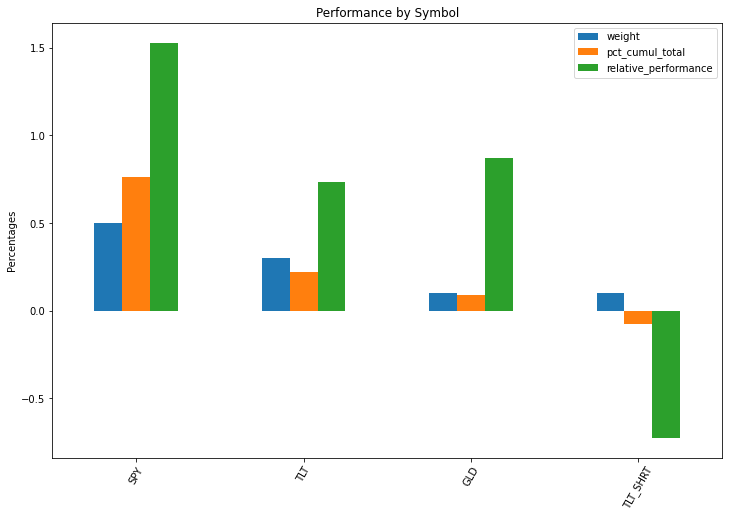

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

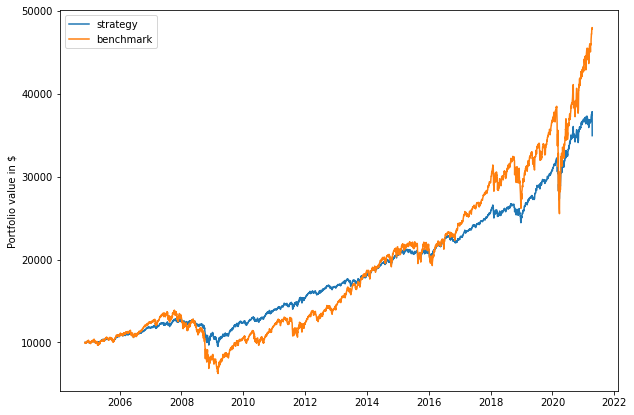

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$34,933.13","$47,762.42"
total_net_profit,"$24,933.13","$37,762.42"
gross_profit,"$27,983.34","$37,762.42"
gross_loss,"-$3,050.21",$0.00


,strategy,benchmark
annual_return_rate,7.92,10.00
max_closed_out_drawdown,-25.88,-54.91
annualized_return_over_max_drawdown,0.31,0.18
best_month,14.14,23.36
worst_month,-15.72,-30.93
sharpe_ratio,0.89,0.59
sortino_ratio,1.06,0.70
monthly_std,2.24,4.53
annual_std,7.78,15.74


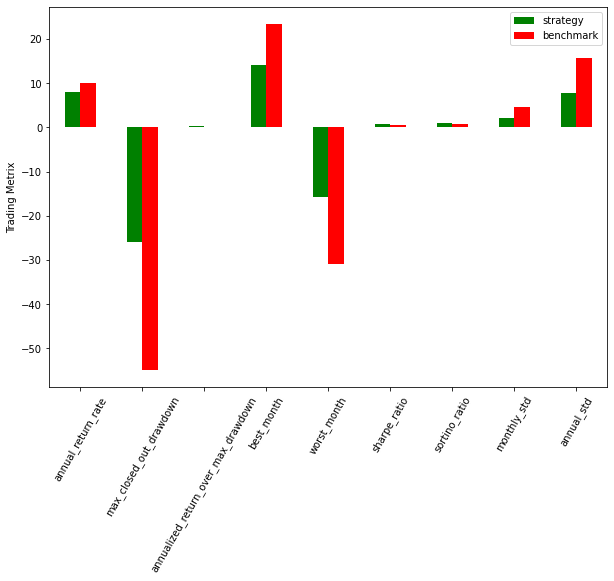

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df